In [7]:
import numpy as np
import deepcut
from keras.models import Model
from keras.layers import Input, Dense, GRU, LSTM, Dropout, Bidirectional
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from random import shuffle
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


# Extract labels and word lists from file.

In [8]:
input_sentence = [i.split("::")[1].replace("\n", '') for i in open("pre_train_input.txt", encoding="utf8")]
input_ans = [i.split("::")[1].replace("\n", '') for i in open("pre_train_ans.txt", encoding="utf-8")]

input_zip = list(zip(input_sentence, input_ans))
shuffle(input_zip)

# tokenize all words
words = [[w for w in deepcut.tokenize(s[0]) if w != ' '] for s in input_zip]

In [9]:
# Extracted only the words around "เขา" in total 21 word
def split_from_kau(words):
    q = []
    flag_found_kau = False
    for w in words:
        q.append(w)
        if "เขา" in w:
            flag_found_kau = True
        elif flag_found_kau:
            if len(q) >= 21:
                break
        else:
            if len(q) > 10:
                q.pop(0)
    return q
# print(index_of_kau(words[0]))
words_split = [split_from_kau(w) for w in words]
print(words_split[-10:])
max_sentence_length = 21 # should not be longer than 21

[['ตำรวจ', 'ได้', 'ออก', 'ตาม', 'หา', 'คน', 'ร้าย', 'หลัง', 'จาก', 'พบ', 'เขา', 'สัตว์', 'จำนวน', 'มาก'], ['น้ำ', 'ตก', 'อยู่', 'ใน', 'เขา'], ['เขา', 'มี', 'ของ', 'สะสม', 'มากมาย', 'เนื่อง', 'จาก', 'เป็น', 'นัก', 'สะสม'], ['แต่ละ', 'ตัว', 'จะ', 'มี', 'เขา', 'ที่', 'ไม่', 'เหมือน', 'กัน'], ['ถ้า', 'ไม่', 'มี', 'เขา', 'รัก', 'ของ', 'เรา', 'จะ', 'ยังคง', 'เป็น', 'ไป', 'ได้', 'ไหม'], ['ฉัน', 'อยาก', 'เห็น', 'อีก', 'ฝาก', 'ของ', 'เนิน', 'เขา', 'ลูก', 'นั้น', 'เธอ', 'พูด', 'พร้อม', 'กับ', 'ส่ง', 'ยิ้ม', 'ให้', 'ผม'], ['เพาะคาปรา', 'ไอบ็อก', 'มี', 'เขา'], ['เมื่อ', 'เช้า', 'มี', 'หมอก', 'เยอะ', 'มาก', 'จน', 'แทบ', 'ไม่', 'เห็น', 'เขา'], ['แอบ', 'ดู', 'ตอน', 'ที่', 'เขา', 'ส่ง', 'ข้อความ', 'มา', 'บอก', 'เธอ'], ['ตะวัน', 'ตก', 'นั้น', 'ขรุขระ', 'และ', 'เป็น', 'ที่', 'สูง', 'โดย', 'มี', 'เทือกเขาหิมาลัย', 'และ', 'เทียน', 'ชาน', 'กั้น', 'เป็น', 'พรมแดน', 'ตาม', 'ธรรมชาติ', 'กับ', 'ประเทศอินเดีย']]


# Load pretrained word vector (only words in vocab).

In [10]:
vocab = set([w for s in words_split for w in s])

pretrained_word_vec_file = open('cc.th.300.vec', 'r',encoding = 'utf-8-sig')
count = 0
vocab_vec = {}
for line in pretrained_word_vec_file:
    if count > 0:
        line = line.split()
        if(line[0] in vocab): 
            vocab_vec[line[0]] = line[1:]
    count = count + 1


# Create word vectors for all sentences.

In [11]:
# ไม่เจอคำที่มีให้ข้าม
word_vector_length = 300
word_vectors = np.zeros((len(words_split),max_sentence_length,word_vector_length))
sample_count = 0
for s in words_split:
    word_count = 0
    for w in s:
        try:
            word_vectors[sample_count,max_sentence_length-word_count-1,:] = vocab_vec[w]
            word_count = word_count+1
        except:
            pass
    sample_count = sample_count+1

# Create RNN model.

In [12]:
inputLayer = Input(shape=(max_sentence_length,word_vector_length,))
rnn = GRU(25, activation='relu')(inputLayer)
# rnn = Dense(5, activation="tanh")(rnn)
# rnn = Bidirectional(LSTM(30, activation='relu'))(inputLayer)
rnn = Dense(5, activation="tanh")(rnn)
# rnn = Dropout(0.5)(rnn)
outputLayer = Dense(3, activation='softmax')(rnn) # for 3 classes
model = Model(inputs=inputLayer, outputs=outputLayer)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print(model.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 21, 300)           0         
_________________________________________________________________
gru_1 (GRU)                  (None, 30)                29790     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 155       
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 30        
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 18        
Total params: 29,993
Trainable params: 29,993
Non-trainable params: 0
_________________________________________________________________
None


# Train RNN Model.

In [13]:
dict_label = {"H":0,"P":1,"M":2}
labels = [dict_label[l[1]] for l in input_zip]
# print(labels)

In [14]:
split_to_train = len(word_vectors)
history = model.fit(word_vectors[:split_to_train], to_categorical(labels[:split_to_train]), epochs=190, batch_size=50, validation_split = 0.1)

 - loss: 0.0299 - accuracy: 0.9944 - val_loss: 0.2664 - val_accuracy: 0.9331
Epoch 57/190
2145/2145 [==============================] - 1s 362us/step - loss: 0.0358 - accuracy: 0.9907 - val_loss: 0.2768 - val_accuracy: 0.9372
Epoch 58/190
2145/2145 [==============================] - 1s 368us/step - loss: 0.0311 - accuracy: 0.9939 - val_loss: 0.2560 - val_accuracy: 0.9331
Epoch 59/190
2145/2145 [==============================] - 1s 375us/step - loss: 0.0256 - accuracy: 0.9953 - val_loss: 0.2443 - val_accuracy: 0.9498
Epoch 60/190
2145/2145 [==============================] - 1s 414us/step - loss: 0.0252 - accuracy: 0.9953 - val_loss: 0.2479 - val_accuracy: 0.9372
Epoch 61/190
2145/2145 [==============================] - 1s 406us/step - loss: 0.0247 - accuracy: 0.9953 - val_loss: 0.2393 - val_accuracy: 0.9456
Epoch 62/190
2145/2145 [==============================] - 1s 373us/step - loss: 0.0242 - accuracy: 0.9949 - val_loss: 0.2505 - val_accuracy: 0.9456
Epoch 63/190
2145/2145 [===========

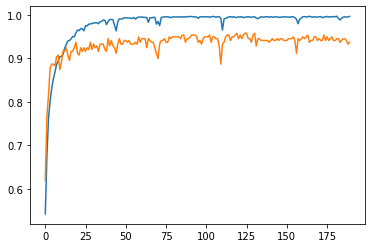

In [15]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()

# Evaluate with a test set.

In [16]:
# try with every trained set and see accuracy overall
y_pred = model.predict(word_vectors)

cm = confusion_matrix(labels, y_pred.argmax(axis=1))
print('Confusion Matrix')
print(cm)
print((cm[0,0]+cm[1,1]+cm[2,2]) / sum([cm[i,j] for i in range(3) for j in range(3)]))

AttributeError: 'list' object has no attribute 'argmax'

In [17]:
model.save("model2.h5") # save model for future use